In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import numpy as np
import math
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report

In [2]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
data_YEB = pd.read_csv("DataSetCoursework_YEB.txt", sep=r'\s{3,}',header=None,engine='python')

In [4]:
data_OCA = pd.read_csv("DataSetCoursework_OCA.txt", sep=r'\s{3,}',header=None,engine='python')

In [5]:
data_YEB.columns=['Neuron_1','Neuron_2,','Neuron_3','Neuron_4','Neuron_5','Neuron_6','Groud_Truth','Trial']
data_OCA.columns=['Neuron_1','Neuron_2,','Neuron_3','Neuron_4','Neuron_5','Neuron_6','Groud_Truth','Trial'] 

In [6]:
data_YEB.head()

,Neuron_1,"Neuron_2,",Neuron_3,Neuron_4,Neuron_5,Neuron_6,Groud_Truth,Trial
0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0


In [7]:
data_OCA.head()

,Neuron_1,"Neuron_2,",Neuron_3,Neuron_4,Neuron_5,Neuron_6,Groud_Truth,Trial
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


## Segregating the data
Pick a few trials, and try and create artificial spikes using these trials

In [8]:
# I will now split the two data into two dataframes. to experiment and create little artificial spikes i can keep track of
df_trials_1_2_3_YEB = data_YEB[data_YEB['Trial'].isin([1, 2, 3])].copy()
df_trials_10_11_12_OCA = data_OCA[data_OCA['Trial'].isin([10, 11, 12])].copy()

# Get the start and end times for df_trials_1_3
start_time_1_2_3 = df_trials_1_2_3_YEB.index[0] * 0.01
end_time_1_2_3 = (df_trials_1_2_3_YEB.index[-1] * 0.01) + 0.01

# Get the start and end times for df_trials_10_11_12_kev
# however the trials 10 to 12 is a bit tricky. we need to convert the time they started from the actual datakev data
start_time_10_11_12 = df_trials_10_11_12_OCA.index[0] * 0.01
end_time_10_11_12 = df_trials_10_11_12_OCA.index[-1] * 0.01  + 0.01

print(f"Trials 1-3 start at {start_time_1_2_3} seconds and end at {end_time_1_2_3} seconds.")
print(f"Trials 10-12 start at {start_time_10_11_12} seconds and end at {end_time_10_11_12} seconds.")

Trials 1-3 start at 0.0 seconds and end at 5.83 seconds.
Trials 10-12 start at 31.1 seconds and end at 36.449999999999996 seconds.


## Leaky Integrate and Fire Model

Revisiting the Leaky integrate and Fire model we got from class 

In [9]:
def LeakyIF_6(input_currents=None, duration=0.2, dt=0.0001, weight=1.0, theta = -0.030):
    """
    Leaky integrate-and-fire model with refractory period, background noise,
    and adaptive threshold.
    Code was written by Emili B-B, Bournemouth University.
    Neuronal Analysis Masters Course.
    Translated to Python from matlab

    Parameters:
        input_currents (dict): A dictionary with keys:
            - 'psc': 1D numpy array of excitatory input current times (seconds).
            - 'U_0': Initial membrane perturbation in volts (default: 0.3 V).
            - 'ipsc': 1D numpy array of inhibitory input current times (seconds).
            - 'I_0': Base amplitude of input current (amps)
        duration (float): Duration of the simulation in seconds.
        dt (float): Time step in seconds.
        weight (float): Scaling factor for the input current amplitude. Default is 1.0.

    Returns:
        time (numpy array): Array of time points.
        U_plot (numpy array): Membrane potential values.
        spike_times (list): Times at which spikes occur.
    """
    # Constants
    tau = 0.020  # Membrane time constant (seconds)
    R = 3e7      # Membrane resistance (ohms)
    U_rest = -0.07  # Resting potential (volts)
    # theta = -0.030  # Threshold for spiking (volts)
    spikeVolt = 0.1  # Voltage of a spike (volts)
    arp = 0.006      # Absolute refractory period (seconds)
    backgroundI = 3e-9  # Background noise current (amps)
    tau_adapt = 0.3     # Adaptive threshold decay time constant
    increase_threshold = 0.012  # Threshold increase after a spike (volts)
    np.random.seed(42) # seed for reproduceability

    # if input_currents is None:
    #     input_currents = {'psc': np.array([0]), 'U_0': 0.3, 'ipsc': np.array([]), 'I_0': 1e-8}

    I_0 = input_currents.get('I_0', 1e-8)
    U_0 = input_currents.get('U_0', 0.3)
    psc = input_currents.get('psc', np.array([]))
    ipsc = input_currents.get('ipsc', np.array([]))

    n_pcs = len(psc)
    n_ipcs = len(ipsc)
    dt_steps = lambda x: np.round(x / dt).astype(int)

    index_pscs = dt_steps(psc)
    index_ipscs = dt_steps(ipsc) if n_ipcs > 0 else np.array([])
    n_steps = int(duration / dt)

    time = np.linspace(0, duration, n_steps + 1)
    U = np.zeros(n_steps + 1)
    U_plot = np.zeros(n_steps + 1)
    I = np.zeros(n_steps + 1)
    U[0] = U_rest
    U_plot[0] = U_rest
    t_spike = -np.inf
    n_spikes = 0
    randI = backgroundI * np.random.normal(0, 1, n_steps)
    theta_adapt = np.full(n_steps + 1, theta)

    spike_times = []

    # Simulation loop
    for i in range(n_steps):
        # Excitatory inputs
        if n_pcs > 0 and i in index_pscs:
            I[i] += I_0 * weight
        # Inhibitory inputs
        if n_ipcs > 0 and i in index_ipscs:
            I[i] -= I_0 * weight

        # Membrane potential update
        dU = (dt / tau) * (U_rest - U[i] + I[i] * R + randI[i] * R)
        U[i + 1] = U[i] + dU
        U_plot[i + 1] = U[i + 1]

        # Spike detection
        if U[i + 1] > theta_adapt[i]:
            # Check ARP if not the first spike
            if n_spikes == 0 or (time[i] >= (t_spike + arp)):
                # Generate spike
                U_plot[i + 1] = spikeVolt
                U[i + 1] = U_rest
                t_spike = time[i]
                n_spikes += 1
                spike_times.append(t_spike)

                # Increase adaptive threshold
                theta_adapt[i + 1] = theta_adapt[i] + increase_threshold
            else:
                # Within refractory period, no spike
                U[i + 1] = U[i]
                U_plot[i + 1] = U[i + 1]
                # Threshold decays toward default
                theta_adapt[i + 1] = theta_adapt[i] + (dt / tau_adapt) * (theta - theta_adapt[i])
        else:
            # No spike, threshold decays toward default
            theta_adapt[i + 1] = theta_adapt[i] + (dt / tau_adapt) * (theta - theta_adapt[i])

    # Plotting the simulation
    plt.figure(figsize=(10,4))
    plt.plot(time, U_plot, color='black')
    plt.axhline(y=theta, color='red', linestyle='--')
    plt.title(f'Leaky I&F: Spikes={n_spikes}, Weight={weight}')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.grid()
    plt.show()

    return time, U_plot, spike_times

In [10]:
def plot_spike_train(data, neuron, start, end,  bin_size=0.01):
    """This function plots the spike train of a single neuron.
        Parameters:
            data (numpy array): The data array.
            neuron (int): The neuron number.
            start (int): The start time of the spike train.
            end (int): The end time of the spike train.
            bin_size (float): The bin size for the time vector.
        
        Plots: The spike train of the neuron got from the data array.
    """

    spikes_data = data[:, :-2]  
    times = np.arange(start, end, bin_size)  # Time vector

    # Plotting
    plt.figure(figsize=(12, 4))

    plt.plot(times, spikes_data[:, neuron])
    plt.title(f"Neuron {neuron + 1}")
    plt.ylabel("Spikes")
    plt.xlabel("Time (s)")

    plt.tight_layout()
    plt.show()

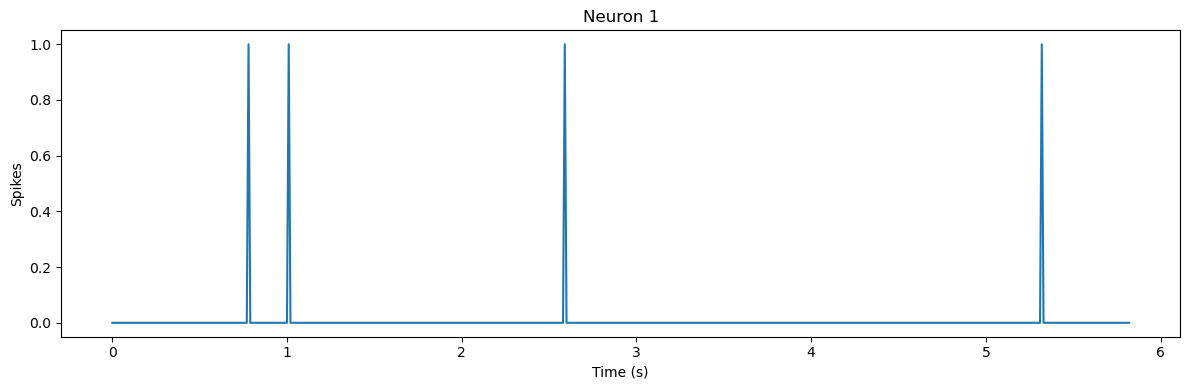

In [11]:
plot_spike_train(df_trials_1_2_3_YEB.values, 0, start_time_1_2_3, end_time_1_2_3)    

# Experimenting with psc
- Since we now know our spike times, we will pass in a psc that is before the spike times and try and see the best way to mimic the neuron spikes. 
- we will pass in the psc that is before the spike times at an offset of 0.004 and increase this offset when necessary. 
- Later we will print the spike times to see how close we are to the actual spike times

In [12]:
# Now looking at the graph we can say that our spike times happem the 0.07, 0.1, 0.26 and 0.54 seconds.
# lets go through the df_trials and get the spike times for the neurons
# getting the rows where the Neuron_1 is 1  and then converting them to seconds
spike_times_n1_YEB = df_trials_1_2_3_YEB['Neuron_1'] == 1
spike_times_n1_YEB = spike_times_n1_YEB[spike_times_n1_YEB == True].index
spike_times_n1_YEB = spike_times_n1_YEB * 0.001
spike_times_n1_YEB

Index([0.078, 0.101, 0.259, 0.532], dtype='float64')

## Artificial Model of Neuron 1_YEB 

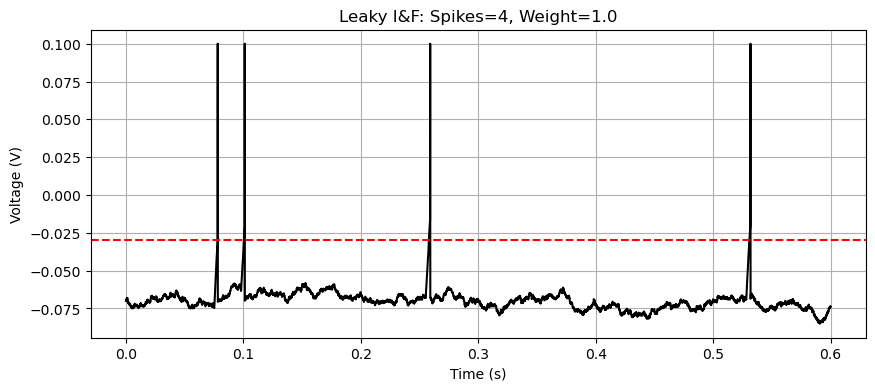

In [ ]:
psc1 = np.arange(0.07509, 0.078,0.0001) #0.00291
psc2 = np.arange(0.098, 0.101,0.0001) #0.003
psc3 = np.arange(0.25519, 0.259, 0.0001) #0.00381
psc4 = np.arange(0.52821, 0.532, 0.0001) #0.0041ssss
psc = np.concatenate([psc1, psc2, psc3, psc4])

input_currents = {'psc': psc, 'I_0': 1e-8, 'U_0': 0.3}

# Run with default weight=1.0
time, U_plot, artificial_spike_times_n1_YEB = LeakyIF_6(input_currents=input_currents, duration = 0.6, dt = 0.0001)

In [14]:
artificial_spike_times_n1_YEB

[np.float64(0.07801300216702783),
 np.float64(0.10101683613935655),
 np.float64(0.2589431571928655),
 np.float64(0.5316886147691282)]


Our Spike times are a bit close to our orignal data. By tweaking the offset of the psc we can have closer artificial spike times to the orginal. For now we will leave them as they are.

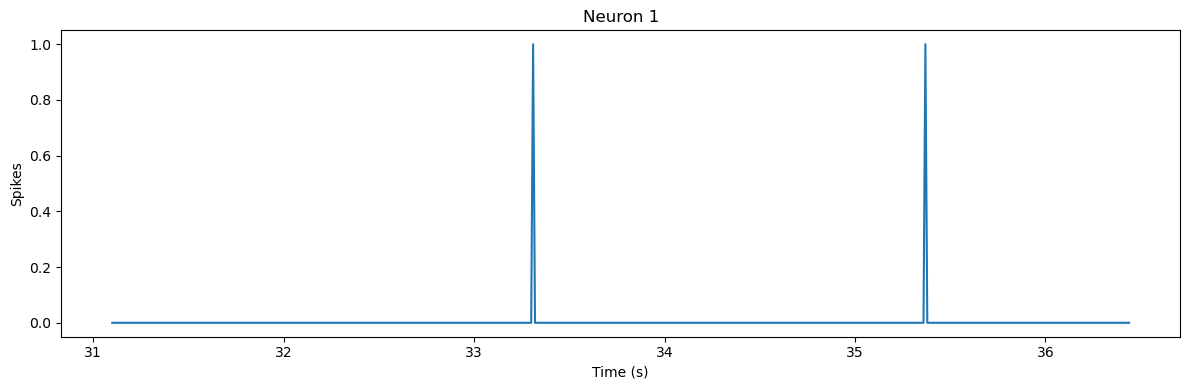

In [15]:
plot_spike_train(df_trials_10_11_12_OCA.values, 0, start_time_10_11_12, end_time_10_11_12)    

In [16]:
spike_times_n1_OCA = df_trials_10_11_12_OCA['Neuron_1'] == 1
spike_times_n1_OCA = spike_times_n1_OCA[spike_times_n1_OCA == True].index
spike_times_n1_OCA = spike_times_n1_OCA * 0.001
spike_times_n1_OCA

Index([3.331, 3.537], dtype='float64')

Above is a bit tricky since our spikes are in the 30000th row of the dataset. This means, its well in the 33seconds mark. Hence to visualize only that section we have to have create intuitively a corresponding 0.6 duration mapping.
So for the aritficial spikes below you would see our start time starting from 0 instead of 31

## Artificial Model of Neuron 1_OCA  

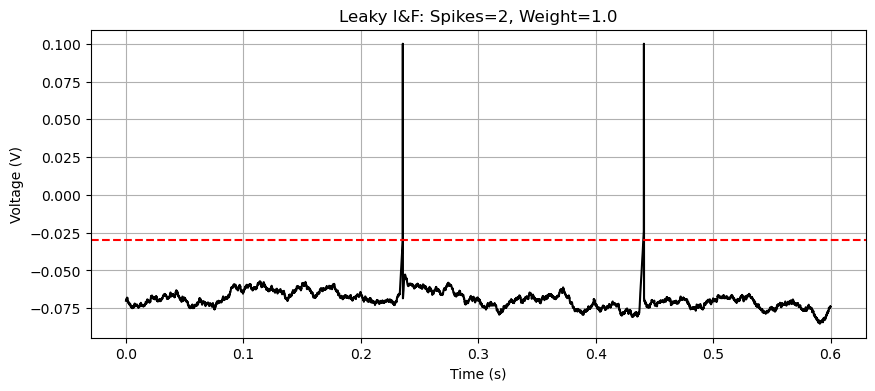

In [17]:
psc1 = np.arange(0.2331, 0.237, 0.0001) #0.004
psc2 = np.arange(0.437, 0.441, 0.0001) #0.004
psc = np.concatenate([ psc1, psc2])

input_currents = {'psc': psc, 'I_0': 1e-8, 'U_0': 0.3}

# Run with default weight=1.0
time, U_plot, artificial_spike_times_n1_OCA = LeakyIF_6(input_currents=input_currents, duration = 0.6, dt = 0.0001)

In [18]:
artificial_spike_times_n1_OCA

[np.float64(0.23563927321220202), np.float64(0.4409734955825971)]

# Creating neuron network
- For DatasetCoursework_YEB we will use Neuron 3 spikes_times as additional psc to pass as input currents into Neuron 1
- And for DatasetCoursework_OCA we will use Neuron 5 and neuron 3
- We will do this for trials 1 to trials 3 for all of them to try and investigate interdependence
- To do that we need a function that converts all the spike times to np.arrange form  `psc1 = np.arrange(offset, spike_time, dt)` and steady increase our offset to consider increase i resistance and possible refractory periods.

In [19]:
def generate_dynamic_psc(spike_times, initial_offset=0.00391, step=0.0001, offset_increment=0.0001):
    """
    Generate and concatenate PSC segments with dynamically increasing offsets.

    Parameters:
    - spike_times: array-like, times of spikes (in seconds)
    - initial_offset: float, initial offset for the first spike (default: 0.00291 seconds)
    - step: float, time resolution for PSC sampling (default: 0.0001 seconds)
    - offset_increment: float, amount to increase the offset for each subsequent spike (default: 0.0001 seconds)

    Returns:
    - psc: numpy array, concatenated PSC segments
    """
    psc = np.array([])  # Initialize the PSC array
    current_offset = initial_offset

    for spike in spike_times:
        # Calculate the start time for this PSC segment
        start = spike - current_offset

        # Generate the PSC segment for this spike
        psc_segment = np.arange(start, spike, step)

        # Concatenate the segment to the overall PSC
        psc = np.concatenate([psc, psc_segment])

        # Increase the offset for the next spike
        current_offset += offset_increment
    
    return psc

## Creating artificial spikes for neuron 3_yeb and converting them to post synaptic currents for neuron 1_yeb. neural network of 2 
- We already know spike times for neuron_1_YEB
- However we need spike time for neuro_3_ YEB to generate good pscs

In [20]:
spike_times_n3_YEB = df_trials_1_2_3_YEB['Neuron_3'] == 1
spike_times_n3_YEB = spike_times_n3_YEB[spike_times_n3_YEB == True].index
spike_times_n3_YEB = spike_times_n3_YEB * 0.001
spike_times_n3_YEB

Index([0.067, 0.325], dtype='float64')

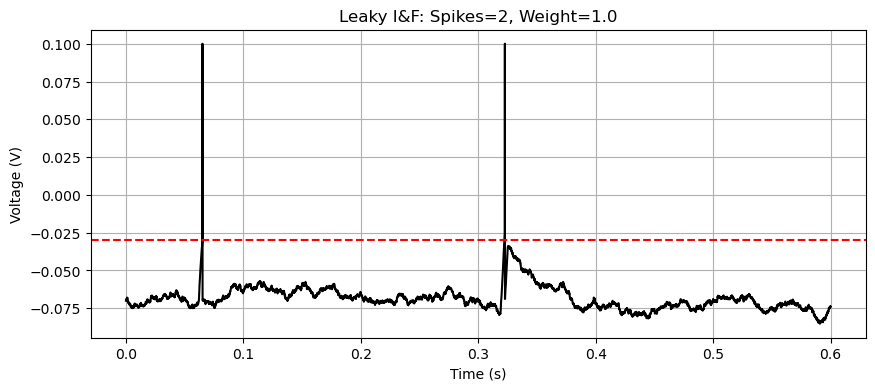

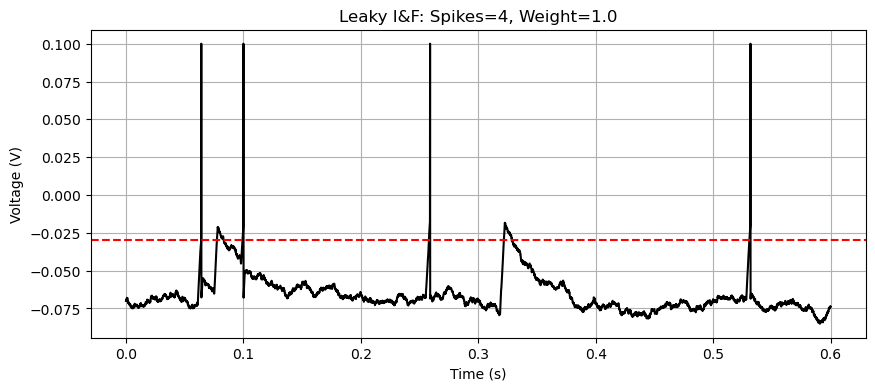

In [21]:
#Plan
# We are going to take the spike times from Neuron 3 and pass them to the function generate_dynamic_psc.
# We need to also consider the spike times for Neuron 1 and generate the psc for Neuron 1.
# Combining the post synaptic currents form Neuron 3 and the pre synaptic currents from Neuron 1 we will have our total psc
# We will then pass this to the LeakyIF_6 function to see if we can generate the same spike times for Neuron 1

psc1 = np.arange(0.062, 0.065, 0.0001) #0.004
psc2 = np.arange(0.319, 0.325, 0.0001) #0.004
psc_n3 = np.concatenate([psc1, psc2])

input_currents = {'psc': psc_n3, 'I_0': 1e-8, 'U_0': 0.3}
time, U_plot, artificial_spike_times_n3_YEB = LeakyIF_6(input_currents=input_currents, duration = 0.6, dt = 0.0001)

# Generate psc from neuron 3
psc1 = np.arange(0.07509, 0.078,0.0001) #0.00291
psc2 = np.arange(0.098, 0.101,0.0001) #0.003
psc3 = np.arange(0.25519, 0.259, 0.0001) #0.00381
psc4 = np.arange(0.52821, 0.532, 0.0001) #0.0041
psc_5 = generate_dynamic_psc(artificial_spike_times_n3_YEB) #post synaptic currents from Neuron 3
psc_n1 = np.concatenate([psc1, psc2, psc3, psc4, psc_5])
psc_n1.sort()

input_currents = {'psc': psc_n1, 'I_0': 1e-8, 'U_0': 0.3}
time, U_plot, artificial_spike_times_n1_YEB = LeakyIF_6(input_currents=input_currents, duration = 0.6, dt = 0.0001)

In [22]:
print(f"Artificial spike times for Neuron 1: {artificial_spike_times_n1_YEB}")
print(f"Artificial spike times for Neuron 3: {artificial_spike_times_n3_YEB}")

Artificial spike times for Neuron 1: [np.float64(0.06401066844474079), np.float64(0.09991665277546258), np.float64(0.25884314052342056), np.float64(0.5316886147691282)]
Artificial spike times for Neuron 3: [np.float64(0.06501083513918986), np.float64(0.32255375895982663)]


## Comparing Artificial Spike times Vs Original Dataset_YEB

In [23]:
def plot_spike_times(spike_times, artificial_spike_times):
    """
    Plot original and artificial spike times on the same axis.

    Parameters:
    - spike_times: array-like, original spike times
    - artificial_spike_times: array-like, artificial spike times
    """
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 2))

    # Plot original spike times
    ax.scatter(spike_times, [1]*len(spike_times),
               color='blue', marker='|', s=100, label='Original')

    # Plot artificial spike times
    ax.scatter(artificial_spike_times, [2]*len(artificial_spike_times),
               color='red', marker='|', s=100, label='Artificial')

    # Customize the y-axis
    ax.set_yticks([1, 2])
    ax.set_yticklabels(['Original', 'Artificial'])

    # Add labels and title
    ax.set_xlabel('Time (s)')
    ax.set_title('Original vs Artificial Spike Times')

    # Add legend
    ax.legend(loc='upper right')

    # Improve layout
    plt.tight_layout()

    # Show the plot
    plt.show()

Artificial spike times vs Original for Neuron 3_YEB


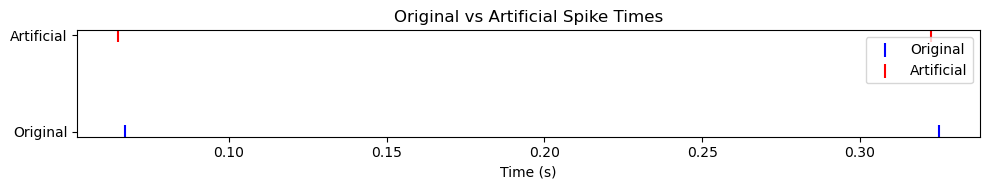

In [24]:
print(f"Artificial spike times vs Original for Neuron 3_YEB")
plot_spike_times(spike_times_n3_YEB, artificial_spike_times_n3_YEB)

Artificial spike times vs Original for Neuron 1_YEB


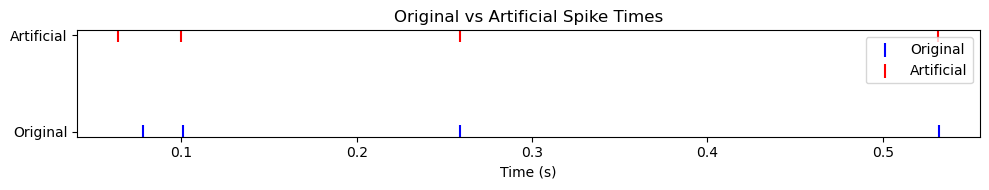

In [25]:
print(f"Artificial spike times vs Original for Neuron 1_YEB")
plot_spike_times(spike_times_n1_YEB, artificial_spike_times_n1_YEB)

### CREATING ARTIFICIAL SPIKES FOR NEURON 3_OCA AND CONVERTING THEM TO POST SYNAPTIC CURRENTS FOR NEURON 5_OCA 

In [26]:
df_trials_1_2_3_OCA = data_OCA[data_OCA['Trial'].isin([1, 2, 3])].copy()
start_time_1_2_3_OCA = df_trials_1_2_3_OCA.index[0] * 0.01
end_time_1_2_3_OCA = (df_trials_1_2_3_OCA.index[-1] * 0.01) + 0.01

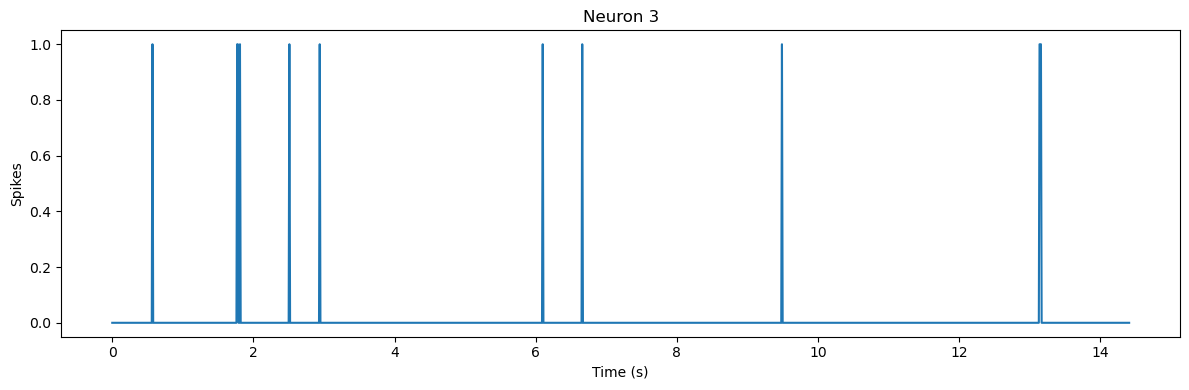

In [27]:
plot_spike_train(df_trials_1_2_3_OCA.values, 2, start_time_1_2_3_OCA, end_time_1_2_3_OCA)    

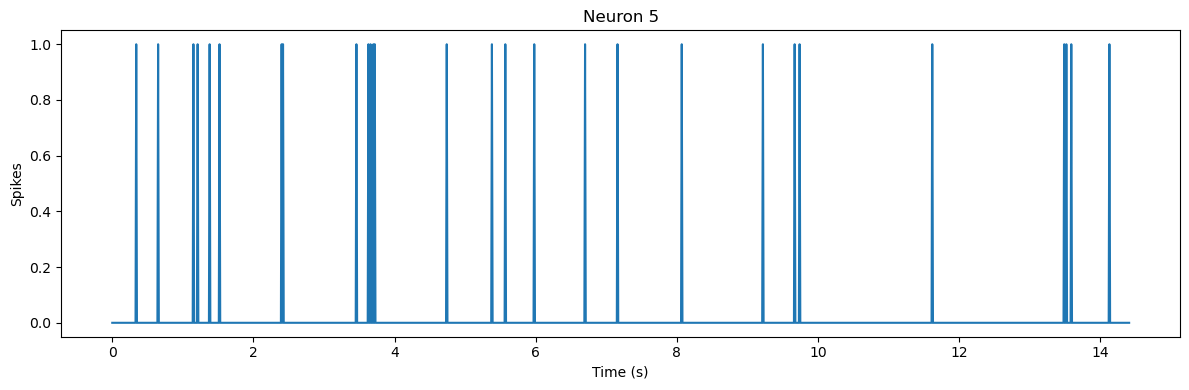

In [28]:
plot_spike_train(df_trials_1_2_3_OCA.values, 4, start_time_1_2_3_OCA, end_time_1_2_3_OCA)   

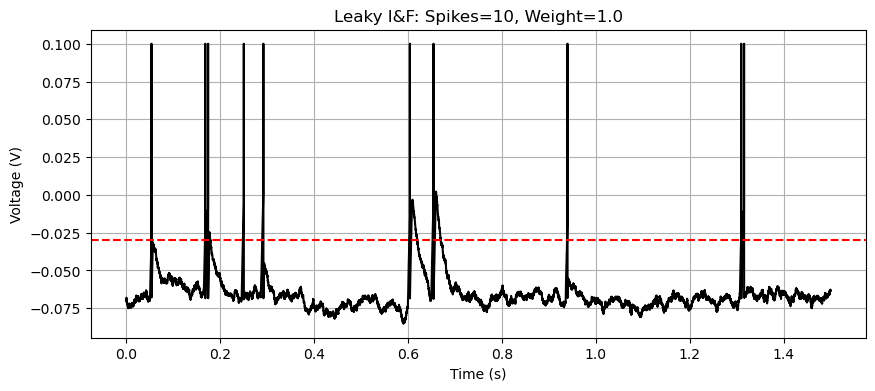

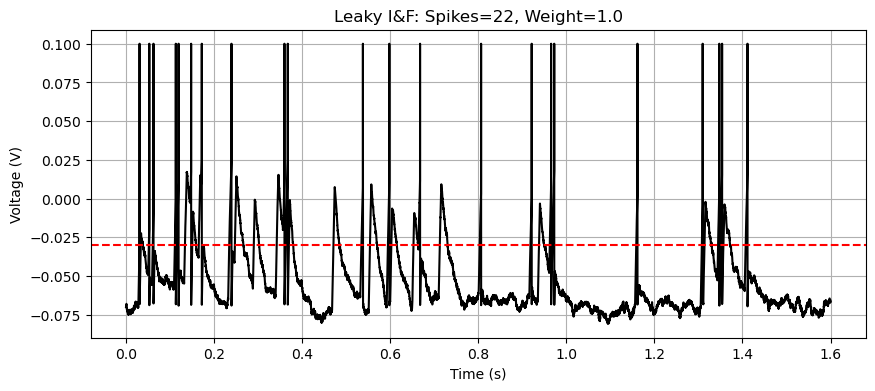

In [29]:
psc1 = np.arange(0.051, 0.057, 0.0001) #0.005
# Burst: 0.177 and 0.178
psc2 = np.arange(0.1659, 0.178, 0.0001) #0.009 
psc3 = np.arange(0.24619, 0.251, 0.0001) #0.004
psc4 = np.arange(0.287, 0.294, 0.0001) #0.004
psc5 = np.arange(0.60, 0.61, 0.0001) #0.004
psc6 = np.arange(0.65, 0.66, 0.0001) #0.004
psc7 = np.arange(0.936, 0.941, 0.0001) #0.004
# Burst: 0.177 and 0.178
psc8 = np.arange(1.307, 1.316, 0.0001) #0.016

psc_n3 = np.concatenate([psc1, psc2, psc3, psc4, psc5, psc6, psc7, psc8])

input_currents = {'psc': psc_n3, 'I_0': 1e-8, 'U_0': 0.3}
time, U_plot, artificial_spike_times_n3_OCA = LeakyIF_6(input_currents=input_currents, duration = 1.5, dt = 0.0001)


# Generate psc from neuron 5 and also passing psc from neuron 3 
psc1 = np.arange(0.028, 0.034, 0.0001)         # Spike at 0.034
psc2 = np.arange(0.059, 0.065, 0.0001)         # Spike at 0.065
# Burst: 0.115 and 0.121
psc3 = np.arange(0.109, 0.121, 0.0001)         # Spikes at 0.115, 0.121
psc4 = np.arange(0.132, 0.138, 0.0001)         # Spike at 0.138
psc5 = np.arange(0.146, 0.152, 0.0001)         # Spike at 0.152
# Burst: 0.24 and 0.242
psc6 = np.arange(0.232, 0.242, 0.0001)         # Spikes at 0.24, 0.242
psc7 = np.arange(0.340, 0.346, 0.0001)         # Spike at 0.346
# Burst: 0.363, 0.366, 0.37, 0.372
psc8 = np.arange(0.357, 0.372, 0.0001)         # Spikes at 0.363, 0.366, 0.37, 0.372
psc9 = np.arange(0.468, 0.474, 0.0001)         # Spike at 0.474
psc10 = np.arange(0.532, 0.538, 0.0001)        # Spike at 0.538
psc11 = np.arange(0.551, 0.557, 0.0001)        # Spike at 0.557
psc12 = np.arange(0.592, 0.598, 0.0001)        # Spike at 0.598
psc13 = np.arange(0.664, 0.67, 0.0001)         # Spike at 0.67
psc14 = np.arange(0.710, 0.716, 0.0001)        # Spike at 0.716
psc15 = np.arange(0.801, 0.807, 0.0001)        # Spike at 0.807
psc16 = np.arange(0.916, 0.922, 0.0001)        # Spike at 0.922
# Burst: 0.967 and 0.974
psc17 = np.arange(0.961, 0.974, 0.0001)        # Spikes at 0.967, 0.974
psc18 = np.arange(1.156, 1.162, 0.0001)        # Spike at 1.162
# Burst: 1.349, 1.352, 1.359
psc19 = np.arange(1.343, 1.359, 0.0001)        # Spikes at 1.349, 1.352, 1.359
psc20 = np.arange(1.405, 1.413, 0.0001)        # Spike at 1.413
psc21 = generate_dynamic_psc(artificial_spike_times_n3_OCA) #post synaptic currents from Neuron 3
psc_n5 = np.concatenate([psc1, psc2, psc3, psc4, psc5, psc6, psc7, psc8, psc9, psc10, psc11, psc12, psc13, psc14, psc15, psc16, psc17, psc18, psc19, psc20, psc21])
psc_n5.sort()

input_currents = {'psc': psc_n5, 'I_0': 1e-8, 'U_0': 0.3}
time, U_plot, artificial_spike_times_n5_OCA = LeakyIF_6(input_currents=input_currents, duration = 1.6, dt = 0.0001)

##### COMPARING ARTIFICIAL SPIKES VS ORIGINAL SPIKE TIMES Dataset_OCA

In [30]:
spike_times_n3_OCA = df_trials_1_2_3_OCA['Neuron_3'] == 1
spike_times_n3_OCA = spike_times_n3_OCA[spike_times_n3_OCA == True].index
spike_times_n3_OCA = spike_times_n3_OCA * 0.001
# spike_times_n3_OCA

spike_times_n5_OCA = df_trials_1_2_3_OCA['Neuron_5'] == 1
spike_times_n5_OCA = spike_times_n5_OCA[spike_times_n5_OCA == True].index
spike_times_n5_OCA = spike_times_n5_OCA * 0.001
# spike_times_n5_OCA

Artificial spike times vs Original for Neuron 3_OCA


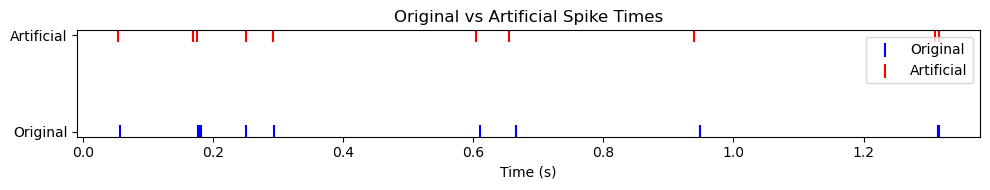

In [31]:
print(f"Artificial spike times vs Original for Neuron 3_OCA")
plot_spike_times(spike_times_n3_OCA, artificial_spike_times_n3_OCA)

Artificial spike times vs Original for Neuron 5_OCA


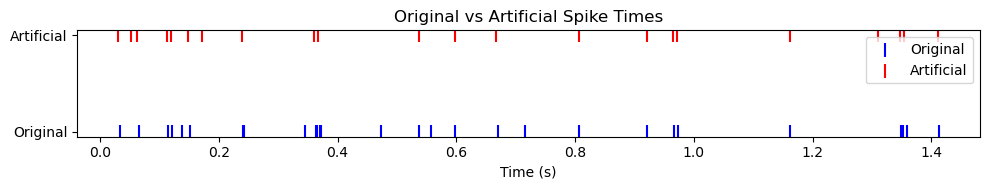

In [32]:
print(f"Artificial spike times vs Original for Neuron 5_OCA")
plot_spike_times(spike_times_n5_OCA, artificial_spike_times_n5_OCA)

# Firing Rate and Classification 
- We need to create artificial spike trains just like the ones in our data set in order to calculate the rates. And compare to our dataset
- We will get our artificial spike times for both dataset. and create columns

Classification of rates 

In [66]:
def rates_estimation_for_neural_network(spikes, neurons=None, window_size=0.2, bin_size=0.01, duration = 0.583):
    """
    Transform spike trains (binary series) to single-trial time-dependent firing rates
    by applying a smoothing rectangular time window. Optionally, process and plot only specified neurons.

    Parameters:
    spikes: numpy array
        Matrix where each column (except the last two) is a neuron and each row is an observation.
        The second-to-last column contains ground truth, and the last column contains the trial number.
    neurons: list of int, optional
        List of neuron indices to process and plot. If None, all neurons are processed.
    window_size: float, optional
        Size of the rectangular smoothing window in seconds (default is 0.2).
    bin_size: float, optional
        Temporal resolution of each row in the spike matrix in seconds (default is 0.01).

    Returns:
    rate: numpy array
        Matrix with time-dependent firing rates for the specified neurons in spikes/second.
        The last two columns contain ground truth and trial numbers, respectively.
    """

    
    if duration > 1.5:
        ground_truth = spikes[:, -2]
        trial_num = spikes[:, -1]
    if duration > 0.6:
        ground_truth = df_trials_1_2_3_OCA.values[:, -2]  # Extract ground truth
        trial_num = df_trials_1_2_3_OCA.values[:, -1]     # Extract trial numbers
    else:
        ground_truth = df_trials_1_2_3_YEB.values[:, -2]
        trial_num = df_trials_1_2_3_YEB.values[:, -1]

    # ground_truth = spikes[:, -2]  # Extract ground truth
    # trial_num = spikes[:, -1]     # Extract trial numbers


    # Determine which neurons to process
    if neurons is None:
        neuron_indices = list(range(spikes.shape[1] - 2))  # All neuron columns
    else:
        # Validate neuron indices
        max_neuron = spikes.shape[1] - 3
        if any(n < 0 or n > max_neuron for n in neurons):
            raise ValueError(f"Neuron indices should be between 0 and {max_neuron}")
        neuron_indices = neurons

    spikes_data = spikes[:, neuron_indices]  # Select specified neurons
    n, m = spikes_data.shape                # Number of rows (time points) and selected neurons
    times = np.arange(0, n * bin_size, bin_size)  # Time vector
    window_steps = int(np.round(window_size / bin_size))  # Steps in one window

    rate = np.zeros((n, m))  # Initialize the rate matrix

    for j in range(m):  # Loop over selected neurons
        smoothed = []
        for i in range(n - window_steps + 1):
            spikes_one_neuron = spikes_data[i:i + window_steps, j]
            rate_in_window = np.sum(spikes_one_neuron) / window_size
            smoothed.append(rate_in_window)

        # Complete the series by repeating the last value
        smoothed = np.concatenate([smoothed, [smoothed[-1]] * (window_steps - 1)])
        rate[:, j] = smoothed

    # Add ground truth and trial numbers back
    rate = np.column_stack((rate, ground_truth, trial_num))

    # Plotting
    num_plots = m * 2  # Each neuron has two plots: spikes and rate
    plt.figure(figsize=(12, 4 * m))  # Adjust figure size based on number of neurons

    for j in range(m):
        # Plot spike trains
        plt.subplot(m, 2, 2 * j + 1)
        plt.plot(times, spikes_data[:, j], drawstyle='steps-pre')
        plt.title(f"Neuron {neuron_indices[j] + 1} Spike Train")
        plt.ylabel("Spikes")
        plt.xlabel("Time (s)")

        # Plot firing rates
        plt.subplot(m, 2, 2 * j + 2)
        plt.plot(times, rate[:, j], 'r')
        plt.title(f"Neuron {neuron_indices[j] + 1} Firing Rate")
        plt.ylabel("Spikes/sec")
        plt.xlabel("Time (s)")

    plt.tight_layout()
    plt.show()

    return rate


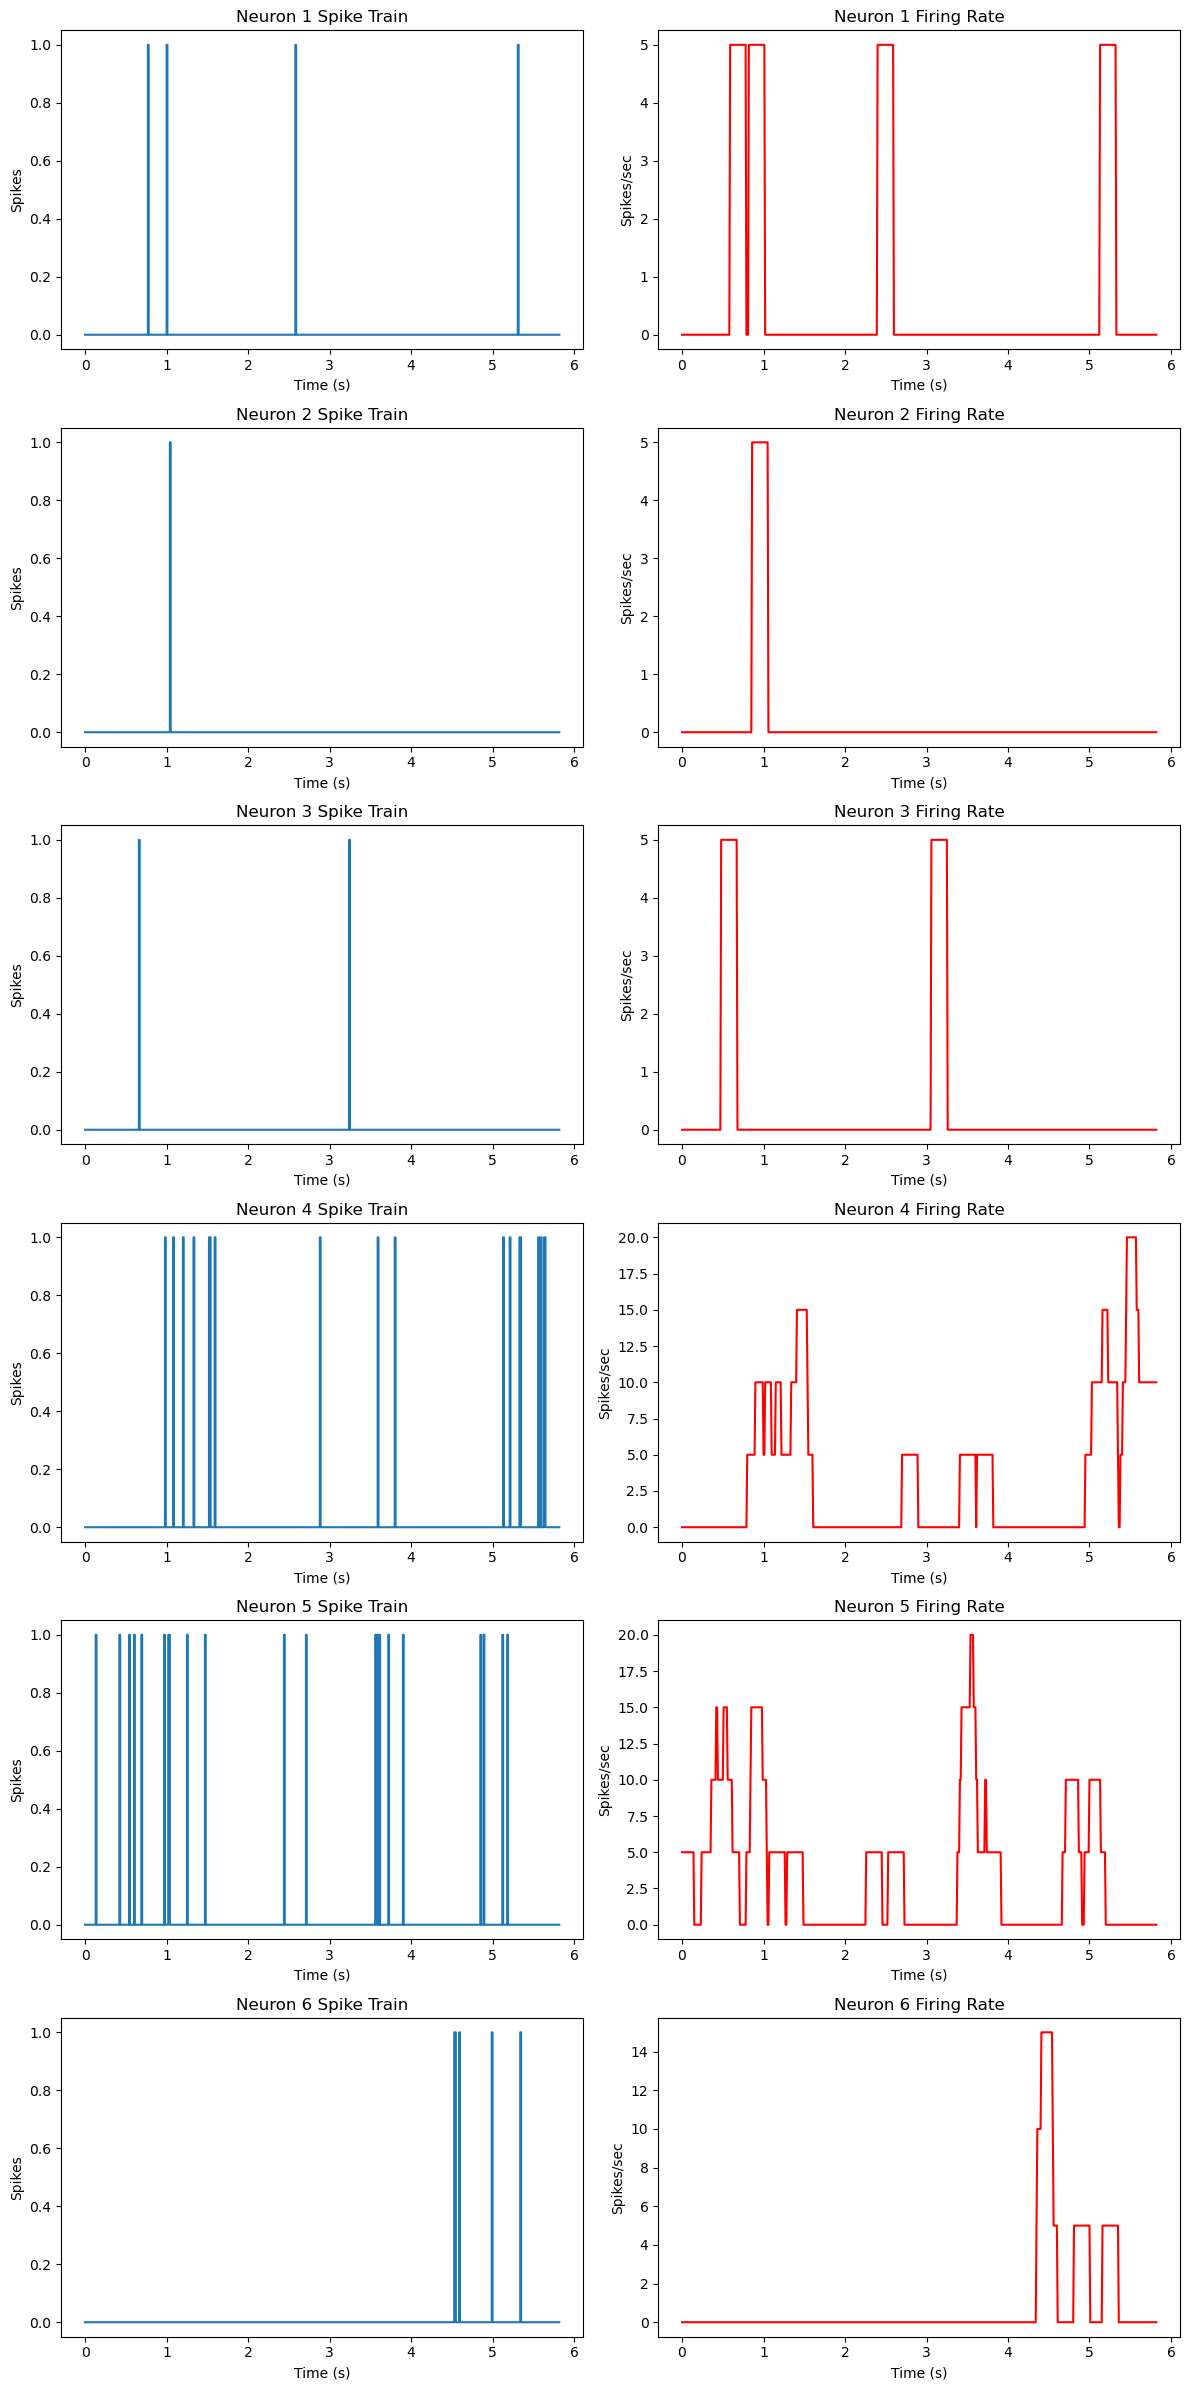

In [67]:
rates_YEB = rates_estimation_for_neural_network(df_trials_1_2_3_YEB.values)

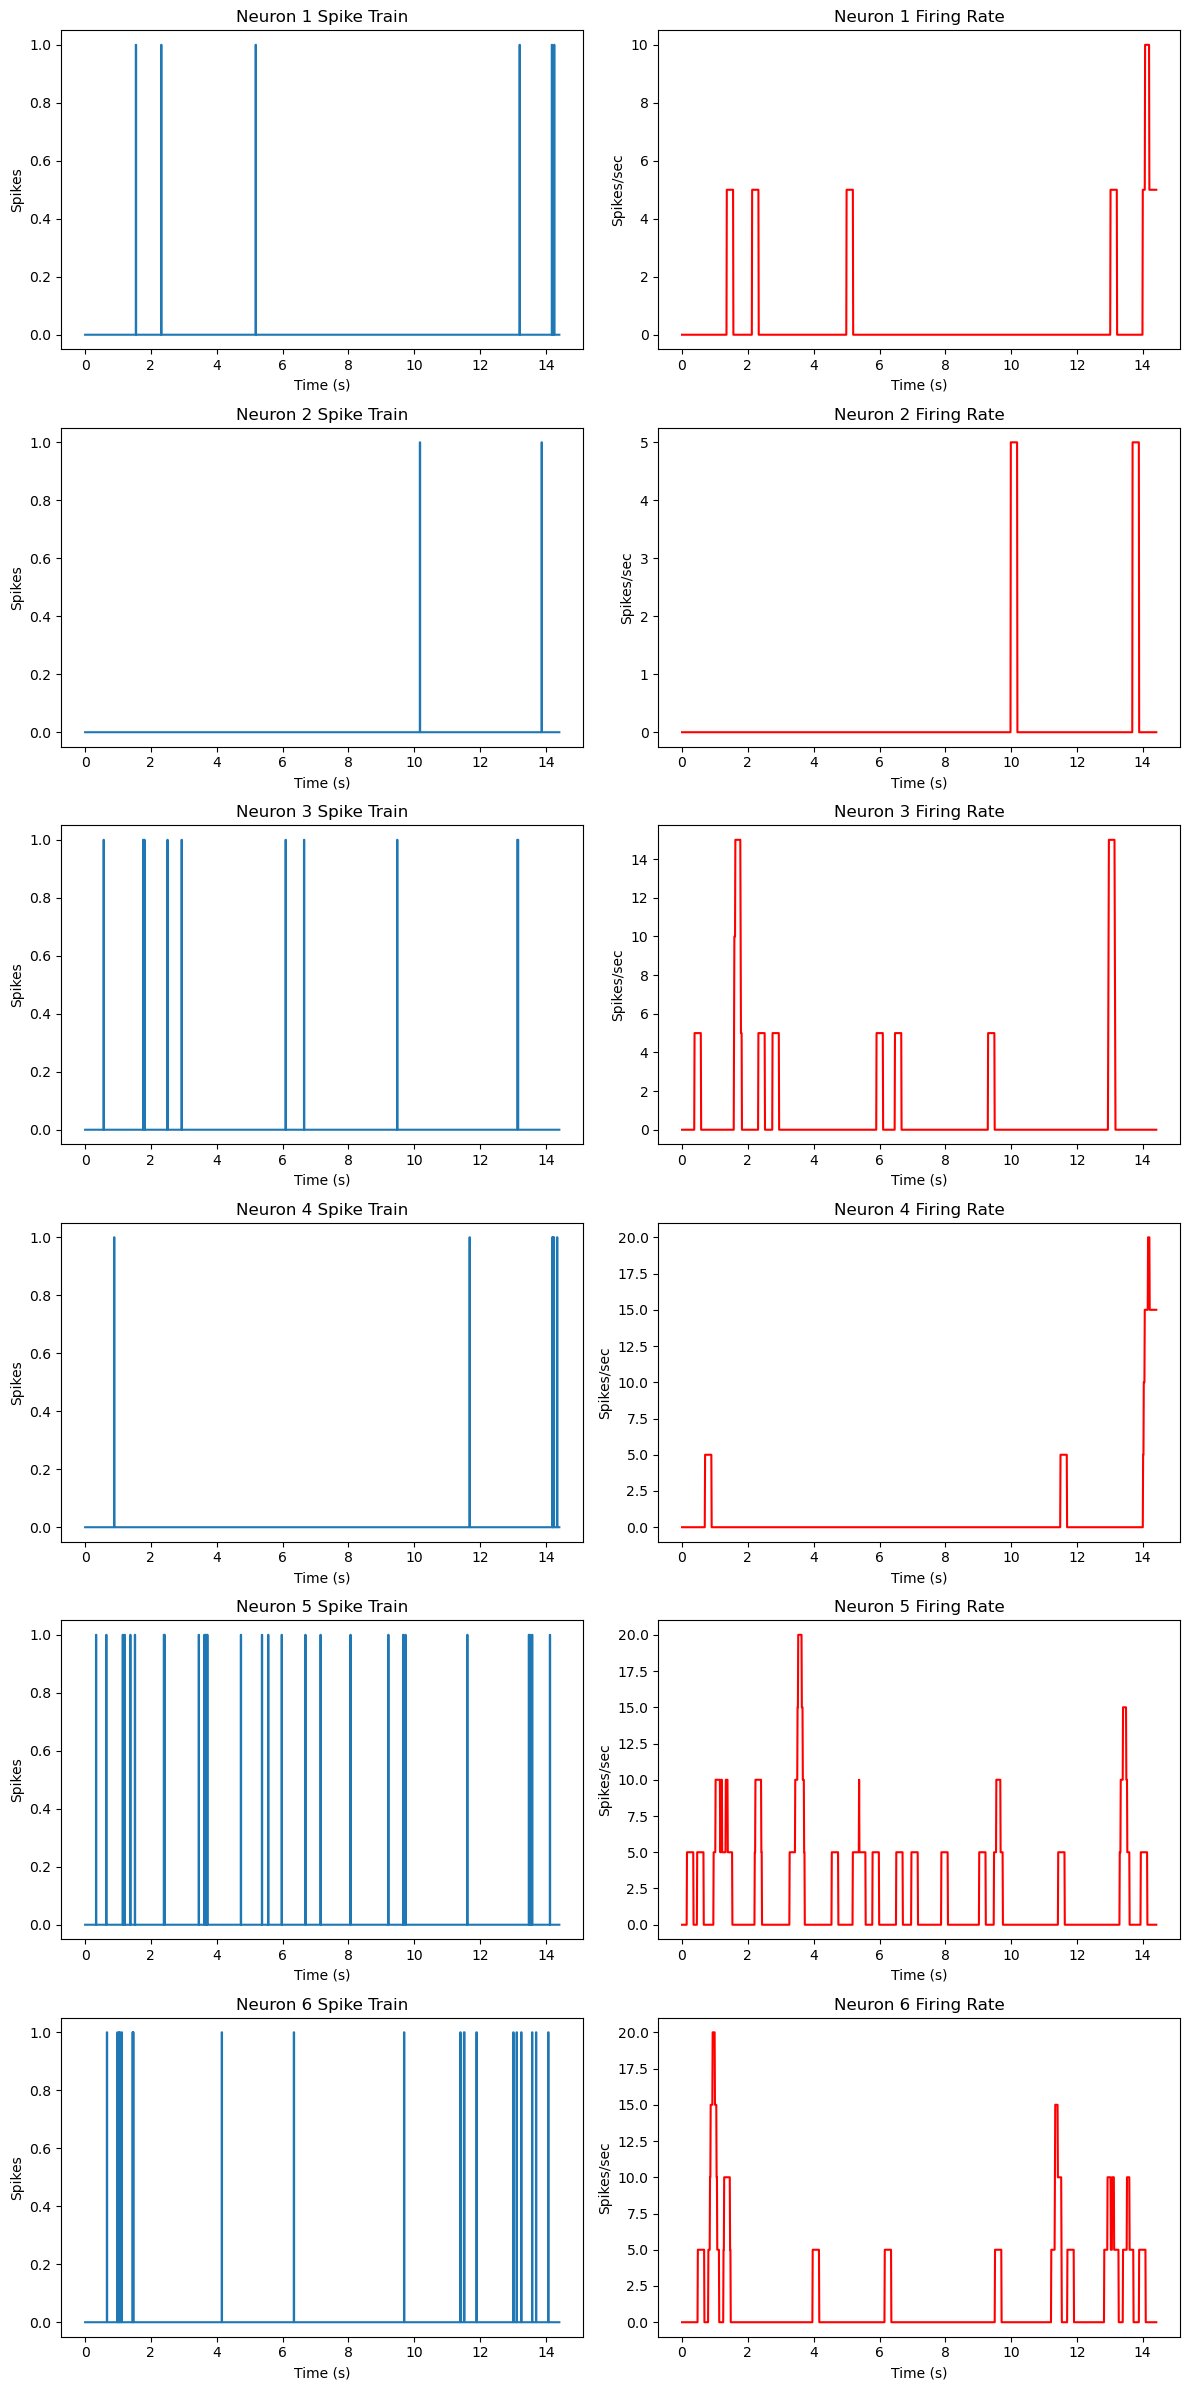

In [69]:
rates_OCA = rates_estimation_for_neural_network(df_trials_1_2_3_OCA.values, duration=1.442)

In [89]:
def create_spikes_from_artificial_times(artificial_spike_times, duration, resolution=0.001):
    """
    Convert artificial spike times into a binary spike train array.

    Parameters:
    - artificial_spike_times: list or array of spike times (in seconds).
    - duration: float, total duration of the spike train (in seconds).
    - resolution: float, temporal resolution of the spike train (default is 0.01 seconds).

    Returns:
    - spikes: numpy array, binary spike train with `1` at spike times.
    """
    # Determine the number of rows based on duration and resolution
    time_steps = int(np.ceil(duration / resolution))
    
    # Create a zero-filled array
    spikes = np.zeros(time_steps)
    
    # Fill in the spike times
    for spike_time in artificial_spike_times:
        row_index = int(np.round(spike_time / resolution))  # Time to row index
        if 0 <= row_index < time_steps:  # Ensure it's within bounds
            spikes[row_index] = 1
    
    return spikes


artificial_n1_rates_YEB = create_spikes_from_artificial_times(artificial_spike_times_n1_YEB, 0.583)
artificial_n3_rates_YEB = create_spikes_from_artificial_times(artificial_spike_times_n3_YEB, 0.583)

print(artificial_n1_rates_YEB.sum())
print(artificial_n3_rates_YEB.sum())

artificial_YEB = pd.DataFrame({
    'Neuron_1': artificial_n1_rates_YEB,
    'Neuron_3': artificial_n3_rates_YEB,
    'Ground_Truth': df_trials_1_2_3_YEB['Groud_Truth'].values,
    'Trial': df_trials_1_2_3_YEB['Trial'].values
})

artificial_YEB


artificial_n3_rates_OCA = create_spikes_from_artificial_times(artificial_spike_times_n3_OCA, 1.442)
artificial_n5_rates_OCA = create_spikes_from_artificial_times(artificial_spike_times_n5_OCA, 1.442)

artificial_OCA = pd.DataFrame({
    'Neuron_3': artificial_n3_rates_OCA,
    'Neuron_5': artificial_n5_rates_OCA,
    'Ground_Truth': df_trials_1_2_3_OCA['Groud_Truth'].values,
    'Trial': df_trials_1_2_3_OCA['Trial'].values
})

4.0
2.0


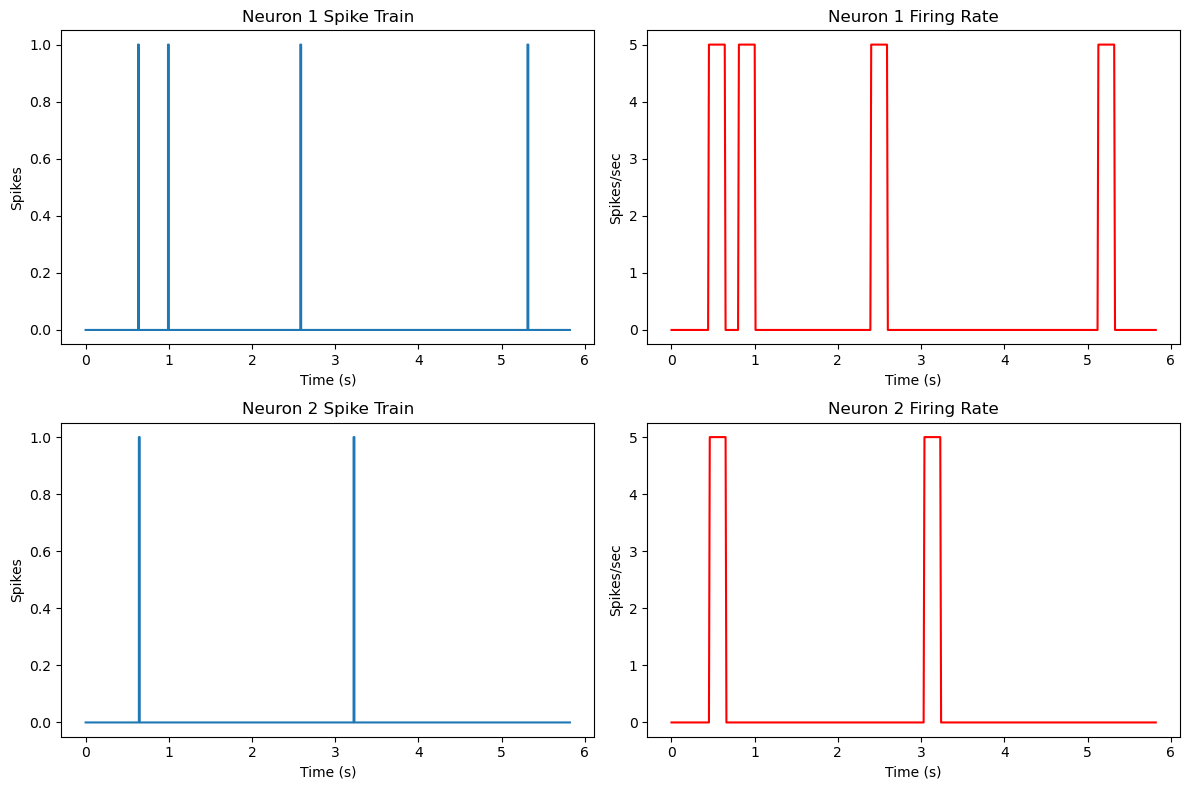

In [92]:
artificial_rates_YEB = rates_estimation_for_neural_network(artificial_YEB.values)

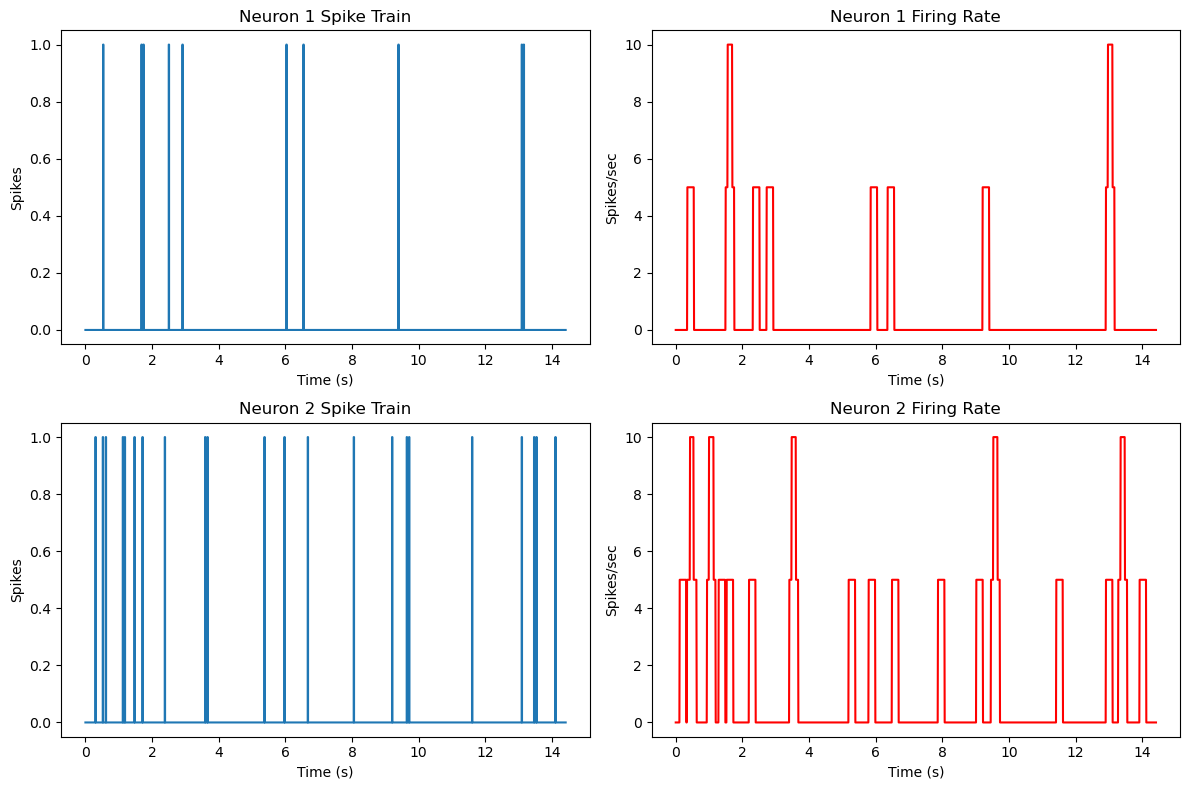

In [93]:
artificial_rates_OCA  = rates_estimation_for_neural_network(artificial_OCA.values, duration=1.442)

In [38]:
#Prepare the data
X_YEB = rates_YEB[:, :-1]
y_YEB = rates_YEB[:, -1]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_YEB, y_YEB, test_size=0.2, random_state=42) # 80% train 20% test


# Logistic Regression
logreg = LogisticRegression(solver='lbfgs', max_iter=1000) # Increased max_iter
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))


# Support Vector Machine (SVM)
svm = SVC(kernel='linear') # You can experiment with different kernels ('rbf', 'poly', etc.)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

# Linear Discriminant Analysis (LDA)
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)
print("LDA Accuracy:", accuracy_score(y_test, y_pred_lda))
print(classification_report(y_test, y_pred_lda))

Logistic Regression Accuracy: 0.4017094017094017
              precision    recall  f1-score   support

         1.0       0.59      0.27      0.37        48
         2.0       0.67      0.06      0.11        33
         3.0       0.35      0.89      0.50        36

    accuracy                           0.40       117
   macro avg       0.54      0.41      0.33       117
weighted avg       0.54      0.40      0.34       117

SVM Accuracy: 0.38461538461538464
              precision    recall  f1-score   support

         1.0       0.55      0.23      0.32        48
         2.0       0.40      0.06      0.11        33
         3.0       0.35      0.89      0.50        36

    accuracy                           0.38       117
   macro avg       0.43      0.39      0.31       117
weighted avg       0.45      0.38      0.32       117

LDA Accuracy: 0.4017094017094017
              precision    recall  f1-score   support

         1.0       0.59      0.27      0.37        48
         2.0 

In [39]:
#Prepare the data
X_OCA = rates_OCA[:, :-1]
y_OCA = rates_OCA[:, -1]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_OCA, y_OCA, test_size=0.2, random_state=42) # 80% train 20% test


# Logistic Regression
logreg = LogisticRegression(solver='lbfgs', max_iter=1000) # Increased max_iter
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))


# Support Vector Machine (SVM)
svm = SVC(kernel='linear') # You can experiment with different kernels ('rbf', 'poly', etc.)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

# Linear Discriminant Analysis (LDA)
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)
print("LDA Accuracy:", accuracy_score(y_test, y_pred_lda))
print(classification_report(y_test, y_pred_lda))

Logistic Regression Accuracy: 1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       238
         2.0       1.00      1.00      1.00        27
         3.0       1.00      1.00      1.00        24

    accuracy                           1.00       289
   macro avg       1.00      1.00      1.00       289
weighted avg       1.00      1.00      1.00       289

SVM Accuracy: 1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       238
         2.0       1.00      1.00      1.00        27
         3.0       1.00      1.00      1.00        24

    accuracy                           1.00       289
   macro avg       1.00      1.00      1.00       289
weighted avg       1.00      1.00      1.00       289

LDA Accuracy: 0.8235294117647058
              precision    recall  f1-score   support

         1.0       0.82      1.00      0.90       238
         2.0       0.00      0.00      0.00 

c:\Users\kevin\anaconda3\envs\Ai\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kevin\anaconda3\envs\Ai\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kevin\anaconda3\envs\Ai\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [40]:
def rates_1(spikes=None, window_size=0.2, bin_size=0.01):
    """
    Transforming spike trains (binary series) to single-trial time-dependent firing rates
    by a smoothing rectangular time window.
    Emili B-B, Bournemouth University.
    Neuronal Analysis Masters Course.
    Suboptimal code, designed for education/portability to other languages.

    Optional inputs:
        spikes: 2D numpy array, each column (except the last one) is a neuron, each row is an
                observation. Last column contains the trial number.
        window_size: Rectangular window size in seconds, see definition of time-dependent firing rate (or just rate).
        bin_size: Maximum resolution of each matrix row, in seconds (must match the
                  criterion used in input #1, matrix 'spikes').
    Output:
        rate: 2D numpy array of length equal to the number of rows in 'spikes' and
              the same number of columns as 'spikes'. Each column is the
              time-dependent firing-rate in spikes/second. The last column indicates the trial number.
    """

    # Load default dataset if no input is provided
    if spikes is None:
        spikes = np.loadtxt('DataSetQ3.txt')

    # Extract trial numbers and spike data
    ground_truth = spikes[:, -2]            # Last column for
    spikes = spikes[:, :-2]              # All columns except the last for spike data
    n, m = spikes.shape                  # Get dimensions
    times = np.arange(0, n * bin_size, bin_size) # Time vector
    window_steps = round(window_size / bin_size) # Number of steps in a time window
    rate = np.zeros((n, m))              # Initialize the rate matrix with zeros

    # Calculate rate for each neuron
    for j in range(m):                   # Iterate over neurons
        smoothed = []
        for i in range(n - window_steps + 1): # Iterate over time points for sliding window
            spikes_one_neuron = spikes[i:i + window_steps, j]   # Select a window for neuron j
            rate_in_this_window = np.sum(spikes_one_neuron) / window_size # Firing rate definition
            smoothed.append(rate_in_this_window)                # Append the calculated rate

        # Extend the smoothed list to match the length 'n' by repeating the last rate value
        smoothed.extend([smoothed[-1]] * (window_steps - 1))
        rate[:, j] = smoothed

    # Add trial number as the last column
    rate = np.column_stack((rate, ground_truth))


    return rate

rates_YEB = rates_1(data_YEB.values)
rates_OCA = rates_1(data_OCA.values)

In [ ]:

artificial_rates_YEB
X_YEB = artificial_rates_YEB[:, :-1]
y_YEB = artificial_rates_YEB[:, -1]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_YEB, y_YEB, test_size=0.2, random_state=42) # 80% train 20% test


# Logistic Regression
logreg = LogisticRegression(solver='lbfgs', max_iter=1000) # Increased max_iter
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))


# Support Vector Machine (SVM)
svm = SVC(kernel='linear') # You can experiment with different kernels ('rbf', 'poly', etc.)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

# Linear Discriminant Analysis (LDA)
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)
print("LDA Accuracy:", accuracy_score(y_test, y_pred_lda))
print(classification_report(y_test, y_pred_lda))

In [95]:


artificial_rates_OCA
X_OCA = artificial_rates_OCA[:, :-1]
y_OCA = artificial_rates_OCA[:, -1]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_YEB, y_YEB, test_size=0.2, random_state=42) # 80% train 20% test


# Logistic Regression
logreg = LogisticRegression(solver='lbfgs', max_iter=1000) # Increased max_iter
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))


# Support Vector Machine (SVM)
svm = SVC(kernel='linear') # You can experiment with different kernels ('rbf', 'poly', etc.)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

# Linear Discriminant Analysis (LDA)
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)
print("LDA Accuracy:", accuracy_score(y_test, y_pred_lda))
print(classification_report(y_test, y_pred_lda))

Logistic Regression Accuracy: 0.728448275862069
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       184
         3.0       0.73      1.00      0.84       676
         4.0       0.00      0.00      0.00        68

    accuracy                           0.73       928
   macro avg       0.24      0.33      0.28       928
weighted avg       0.53      0.73      0.61       928



c:\Users\kevin\anaconda3\envs\Ai\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kevin\anaconda3\envs\Ai\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kevin\anaconda3\envs\Ai\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SVM Accuracy: 0.728448275862069
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       184
         3.0       0.73      1.00      0.84       676
         4.0       0.00      0.00      0.00        68

    accuracy                           0.73       928
   macro avg       0.24      0.33      0.28       928
weighted avg       0.53      0.73      0.61       928

LDA Accuracy: 0.7262931034482759
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       184
         3.0       0.73      1.00      0.84       676
         4.0       0.25      0.01      0.03        68

    accuracy                           0.73       928
   macro avg       0.33      0.34      0.29       928
weighted avg       0.55      0.73      0.61       928



c:\Users\kevin\anaconda3\envs\Ai\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kevin\anaconda3\envs\Ai\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kevin\anaconda3\envs\Ai\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kevin\a

In [42]:
X_OCA = rates_OCA[:, :-1]
y_OCA = rates_OCA[:, -1]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_OCA, y_OCA, test_size=0.2, random_state=42) # 80% train 20% test


# Logistic Regression
logreg = LogisticRegression(solver='lbfgs', max_iter=1000) # Increased max_iter
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))


# Support Vector Machine (SVM)
svm = SVC(kernel='linear') # You can experiment with different kernels ('rbf', 'poly', etc.)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

# Linear Discriminant Analysis (LDA)
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)
print("LDA Accuracy:", accuracy_score(y_test, y_pred_lda))
print(classification_report(y_test, y_pred_lda))

Logistic Regression Accuracy: 0.5134297520661157
              precision    recall  f1-score   support

         1.0       0.56      0.92      0.70       409
         2.0       0.51      0.39      0.44       197
         3.0       0.31      0.14      0.19       190
         4.0       0.25      0.09      0.14       172

    accuracy                           0.51       968
   macro avg       0.41      0.39      0.37       968
weighted avg       0.45      0.51      0.45       968

SVM Accuracy: 0.493801652892562
              precision    recall  f1-score   support

         1.0       0.56      0.92      0.69       409
         2.0       0.50      0.20      0.29       197
         3.0       0.25      0.25      0.25       190
         4.0       0.59      0.08      0.13       172

    accuracy                           0.49       968
   macro avg       0.48      0.36      0.34       968
weighted avg       0.49      0.49      0.43       968

LDA Accuracy: 0.48140495867768596
              p

In [94]:
X_OCA = artificial_OCA[:, :-2]
y_OCA = rates_OCA[:, -2]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_OCA, y_OCA, test_size=0.2, random_state=42) # 80% train 20% test


# Logistic Regression
logreg = LogisticRegression(solver='lbfgs', max_iter=1000) # Increased max_iter
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))


# Support Vector Machine (SVM)
svm = SVC(kernel='linear') # You can experiment with different kernels ('rbf', 'poly', etc.)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

# Linear Discriminant Analysis (LDA)
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)
print("LDA Accuracy:", accuracy_score(y_test, y_pred_lda))
print(classification_report(y_test, y_pred_lda))

InvalidIndexError: (slice(None, None, None), slice(None, -2, None))